## Importing and Loading DataSet Files

In [4]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')
products_df = pd.read_csv('Products.csv')



## Preprocessing,Normalizing

In [5]:
# Preprocessing
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], format='%d-%m-%Y %H:%M')
customer_transactions = (
    transactions_df
    .groupby('CustomerID')
    .agg(
        total_spent=('TotalValue', 'sum'),
        total_quantity=('Quantity', 'sum'),
        unique_products=('ProductID', 'nunique')
    )
    .reset_index()
)
customers_transactions = customers_df.merge(customer_transactions, on='CustomerID', how='left').fillna(0)

# Normalize numerical features
numeric_columns = customers_transactions.select_dtypes(include=['number']).columns
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customers_transactions[numeric_columns])



## Clustering using sklearn k-means algorithm

In [6]:
# Clustering with K-Means
db_index_scores = []
cluster_range = range(2, 11)
cluster_models = {}

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(normalized_features)
    db_index = davies_bouldin_score(normalized_features, cluster_labels)
    db_index_scores.append(db_index)
    cluster_models[k] = (kmeans, cluster_labels)

# Optimal number of clusters
optimal_k = cluster_range[db_index_scores.index(min(db_index_scores))]
optimal_model, optimal_labels = cluster_models[optimal_k]

# Add cluster labels to dataset
customers_transactions['Cluster'] = optimal_labels



## Visualization of Clusters

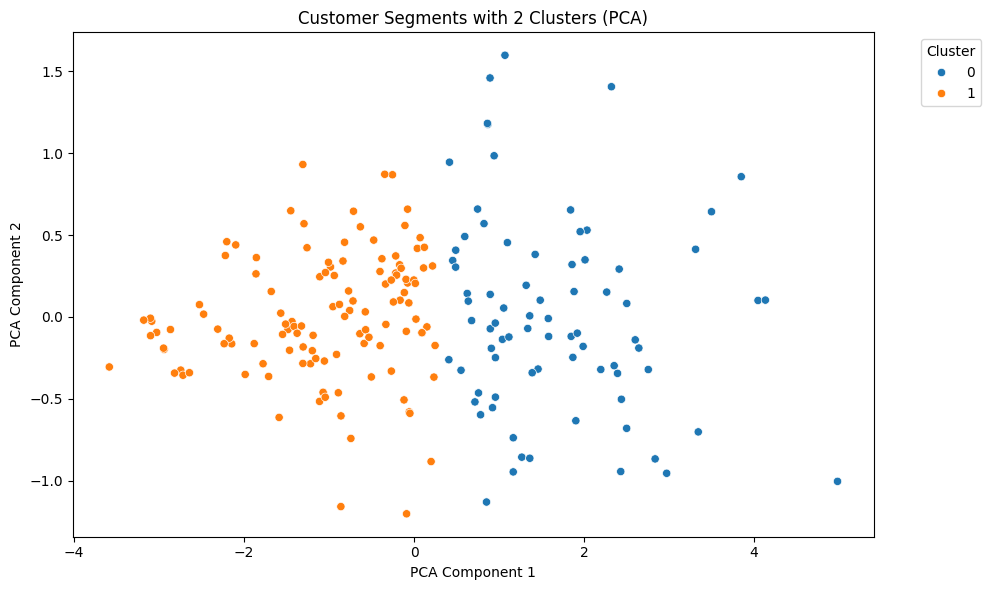

In [10]:
# PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(normalized_features)
customers_transactions['PCA1'] = pca_components[:, 0]
customers_transactions['PCA2'] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette=sns.color_palette("tab10", n_colors=optimal_k),
    data=customers_transactions,
    legend='full'
)
plt.title(f'Customer Segments with {optimal_k} Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save results
customers_transactions[['CustomerID', 'Cluster', 'PCA1', 'PCA2']].to_csv('Customer_Clusters.csv', index=False)
